1. Mount Google Drive and import necessary libraries


In [1]:
"""from google.colab import drive
drive.mount('/content/drive')
"""
# Set up auto-reloading modules from the working directory
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

# Ignore specific warning types
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Suppress absl warnings
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [2]:
!pip install tensorflow

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import cv2
import os
import pickle

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.applications import vgg16, densenet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import plot_model
from IPython.display import Image, display
import os

# Prediction function with denormalization
def predict_and_plot(image_path, model, model_name, min_age, max_age):
    test_image = load_img(image_path, target_size=(224, 224))
    test_image = img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0) / 255.0
    predicted_age = model.predict(test_image)[0][0]
    predicted_age = predicted_age * (max_age - min_age) + min_age
    print(predicted_age)

    # Plot the test image with predicted age
    plt.figure()
    plt.title(f'Model: {model_name} Predicted age: {predicted_age}')
    plt.imshow(image.load_img(image_path))
    plt.show()
    return predicted_age

def plot_label_distribution(labels, split, class_names, max_age, min_age):
    labels = labels * (max_age - min_age) + min_age
    class_names = np.sort(class_names)
    # Given a flat list of integers `labels`, counts how many of each
    counts = [ sum(labels == c) for c in range(len(class_names)) ]

    # Plot a histogram of the distribution
    plt.title(f'{split} distribution')
    plt.bar(range(len(class_names)), counts)
    plt.xlabel('Class')
    plt.ylabel('Num examples')
    plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=90)  # Set the x-axis labels
    plt.show()

def plot_model_structure(model, model_name):
    try:
        file_name = model_name + '.png'
        print(f"File will be saved as: {file_name}")
        try:
            plot_model(model, to_file=file_name, show_shapes=True, show_layer_names=True)
        except Exception as plot_error:
            print(f"plot_model error: {plot_error}")
        if os.path.exists(file_name):
            # Display the model structure
            display(Image.open(file_name))
        else:
            print(f"Failed to save model structure image as {file_name}. File not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

def plot_training_history(history):  
    # Plot training & validation MAE values
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_real_vs_predicted(test_Y, y_pred, min_age, max_age ):
    test_Y = test_Y * (max_age - min_age) + min_age
    y_pred = y_pred * (max_age - min_age) + min_age
    plt.scatter(test_Y, y_pred, color='blue')
    plt.plot(test_Y, test_Y, color='red', linestyle='--')  # Plotting the diagonal line for reference
    plt.title('Real vs Predicted Values')
    plt.xlabel('Real Values')
    plt.ylabel('Predicted Values')
    plt.show()


2. Set path of image folder and shuffle image paths


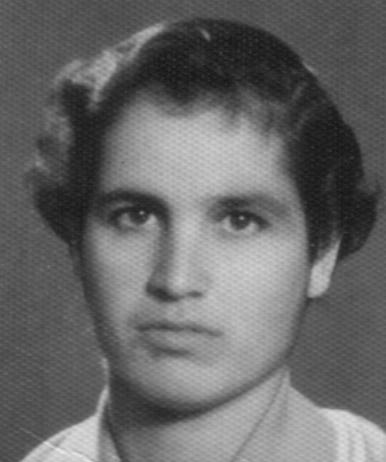

In [4]:
# Set path of image folder
from PIL import Image

IMAGEPATH = "./images"

# Change the filename to view other examples from the dataset
display(Image.open(IMAGEPATH + '/20/20_1.JPG'))

# Grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(IMAGEPATH)))
# random.seed()
# random.shuffle(imagePaths)

In [5]:
model_name_list =[]
batch_list = []
optimizer_list = []
learning_rate_list = []
epoch_list = []
train_mae_list = []
val_mae_list = []
train_mse_list = []
val_mse_list =[]
r_square_list = []

3. Initialize parameters and prepare data


In [6]:
# Initialize the number of epochs to train for, initial learning rate, and batch size
BATCH_SIZE = 32
IMAGE_SIZE = 224
num_classes = 0  # Number of classes for classification

# Initialize the data and labels
data = []
labels = []
classNum = []
classNames = []

# Get a list of subfolders as labels
subfolders = [f.path for f in os.scandir(IMAGEPATH) if f.is_dir()]

i = 0
for folder in subfolders:
    s = folder.split("/")[-1]  # Image file name
    classNum.append(i)
    classNames.append(s)
    i = i + 1

num_classes = len(classNum)

4. Create training data and labels


In [7]:
# Create training data and labels
for imagePath in imagePaths:
    # Load the image, pre-process it, and store it in the data list
    img = cv2.imread(imagePath)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = img_to_array(img)
    data.append(img)

    # Extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-2]

    i = 0
    for name in classNames:
        if label == name:
            label = classNum[i]
            break
        i += 1
    labels.append(label)

In [8]:
# Convert data and labels to numpy arrays in preparation for model training
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Normalize the labels
MIN_AGE = labels.min()
MAX_AGE = labels.max()
labels = (labels - MIN_AGE) / (MAX_AGE - MIN_AGE)

# Split the data into training (80%) and testing (20%)
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

assert not np.any(np.isnan(trainX)), "trainX contains NaNs"
assert not np.any(np.isnan(trainY)), "trainY contains NaNs"
assert not np.any(np.isinf(trainX)), "trainX contains infinite values"
assert not np.any(np.isinf(trainY)), "trainY contains infinite values"

assert not np.any(np.isnan(testX)), "testX contains NaNs"
assert not np.any(np.isnan(testY)), "testY contains NaNs"
assert not np.any(np.isinf(testX)), "testX contains infinite values"
assert not np.any(np.isinf(testY)), "testY contains infinite values"

# Plot train and test distribution

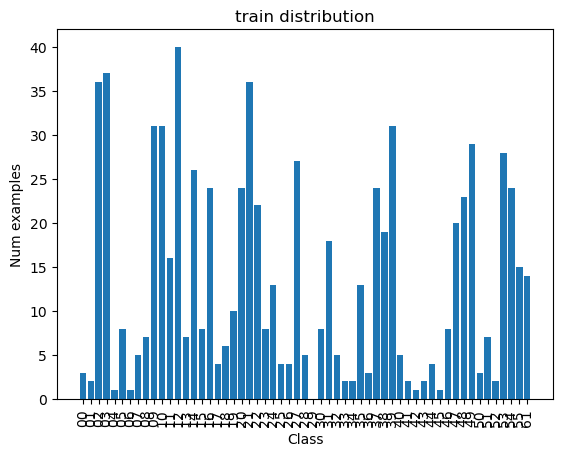

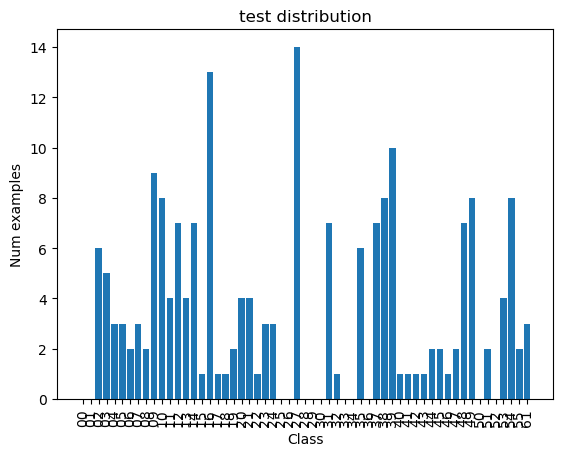

In [9]:
plot_label_distribution(trainY, 'train', classNames, MAX_AGE, MIN_AGE)
plot_label_distribution(testY, 'test', classNames, MAX_AGE,MIN_AGE )

In [10]:
def compile_model(model, optimizer, lr):
    if optimizer == "sgd":
        optimizer_instance = keras.optimizers.SGD(learning_rate=lr, clipvalue=1.0)
    elif optimizer == "adam":
        optimizer_instance = keras.optimizers.Adam(learning_rate=lr)
    #compile
    model.compile(optimizer=optimizer_instance, loss='mean_squared_error', metrics=['mae', 'mse'])

Simple CNN Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

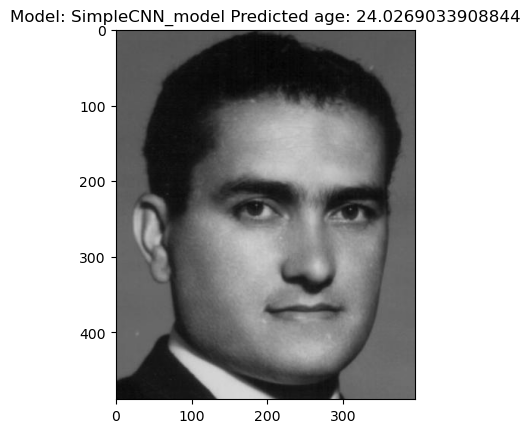

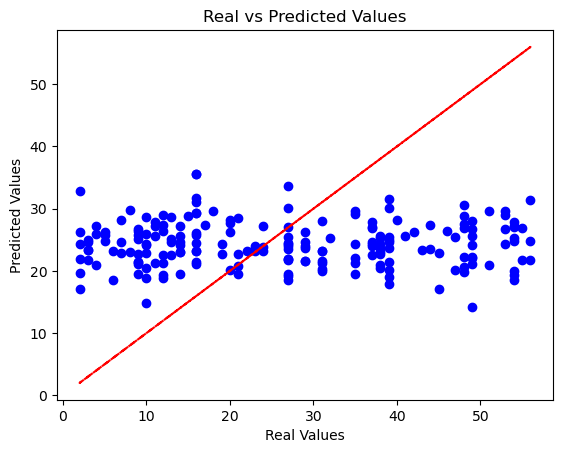

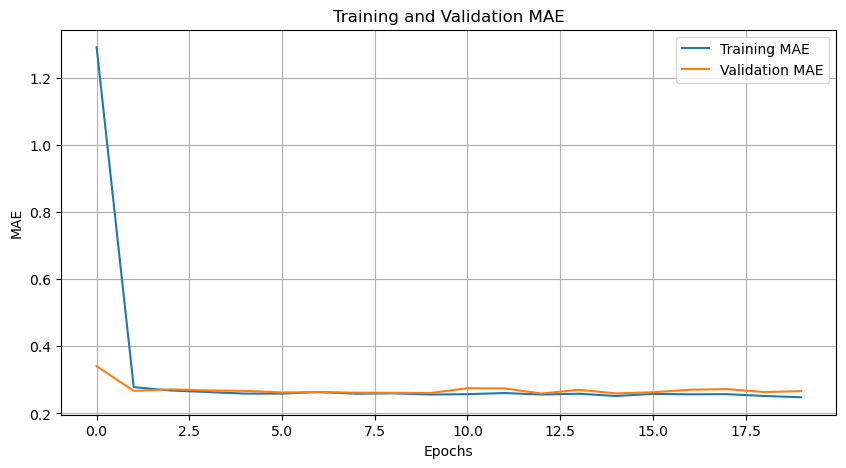

File will be saved as: SimpleCNN_model.png


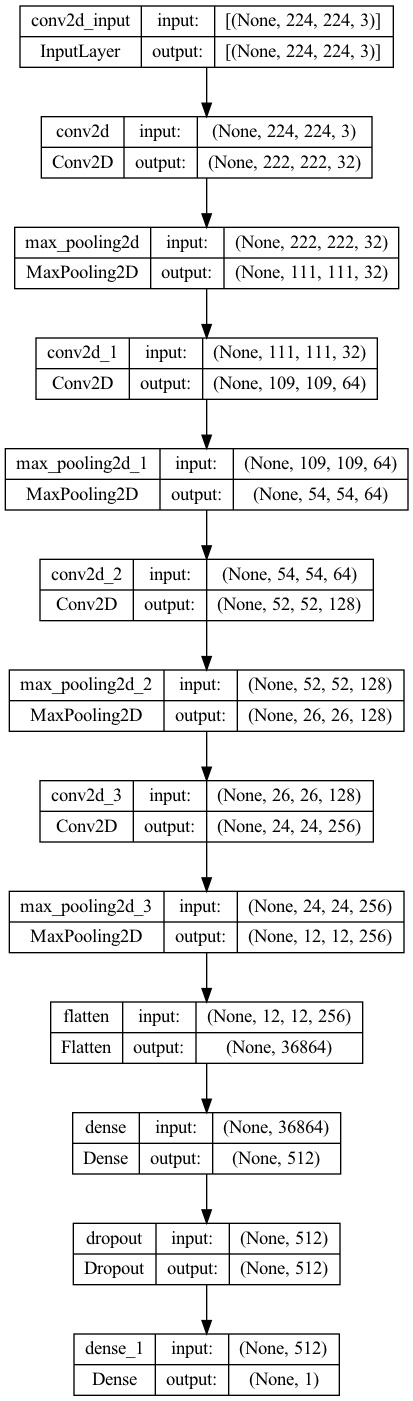

In [11]:
# Create the simple CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))  # Linear activation for regression

# Print the model summary
print(model.summary())

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

# Train the model
history = model.fit(trainX, trainY, validation_split=0.1, batch_size=BATCH_SIZE, epochs=20, verbose=2)

# Predict ages for the test set
y_pred = model.predict(testX)

# Calculate R2 score
r2 = r2_score(testY, y_pred)
print(f'R2 Score: {r2}')

# Save the model
model_name = 'SimpleCNN_model'
model.save(model_name + '.h5')    
saved_model = load_model('./' + model_name + '.h5')
testfile = IMAGEPATH + '/28/28_2.JPG'
predict_and_plot(testfile, saved_model,model_name, MIN_AGE, MAX_AGE)
plot_real_vs_predicted(testY, y_pred, MIN_AGE, MAX_AGE)
plot_training_history(history)
plot_model_structure(model, model_name)

# Densenet Model

In [12]:
def densenet_model(trainX, trainY, testX, testY, model_name, optimizer, image_size, batch_size, epochs, lr):
    densenet_model = densenet.DenseNet201(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    
    # Freeze the layers
    for layer in densenet_model.layers:
      layer.trainable = False
    
    # Create the model
    model = Sequential()
    # Add the DenseNet201 base model
    model.add(densenet_model)
    # Add additional convolutional layer
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))

    print(model.summary())
    
    # call Compile function
    compile_model(model, optimizer, lr)
    
    # Train the model
    history = model.fit(trainX, trainY, validation_split=0.2, batch_size=batch_size, epochs=epochs, verbose=2)
    y_pred = model.predict(testX)
    r2 = r2_score(testY, y_pred)
    model.save(model_name + '.h5')    

    #save the metrics in lists
    model_name_list.append(model_name.split('_')[0])
    optimizer_list.append(optimizer)
    batch_list.append(batch_size)
    learning_rate_list.append(lr)
    epoch_list.append(epochs)
    train_mae_list.append(history.history['mae'][-1])
    val_mae_list.append(history.history['val_mae'][-1])
    train_mse_list.append(history.history['mse'][-1])
    val_mse_list.append(history.history['val_mse'][-1])
    r_square_list.append(r2)

    #plotting
    plot_real_vs_predicted(testY, y_pred, MIN_AGE, MAX_AGE)
    plot_training_history(history)
    plot_model_structure(model, model_name)

In [13]:
def train_test_densenet(trainX, trainY, testX, testY, optimizer, image_size, batch_size, epochs, lr):
    model_name = f'Densenet_model_{epochs}_epoch_{lr}_LR_{optimizer}_optimizer_{batch_size}_batch_size'
    densenet_model(trainX, trainY, testX, testY, model_name, optimizer, image_size, batch_size, epochs, lr)
    # Load the trained model
    saved_model = load_model('./' + model_name + '.h5')
    # Test prediction
    testfile = IMAGEPATH + '/28/28_2.JPG'
    predict_and_plot(testfile, saved_model, model_name, MIN_AGE, MAX_AGE)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 512)         8847872   
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                      

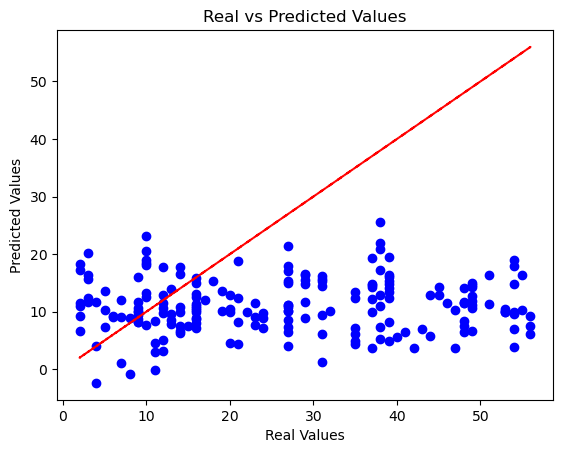

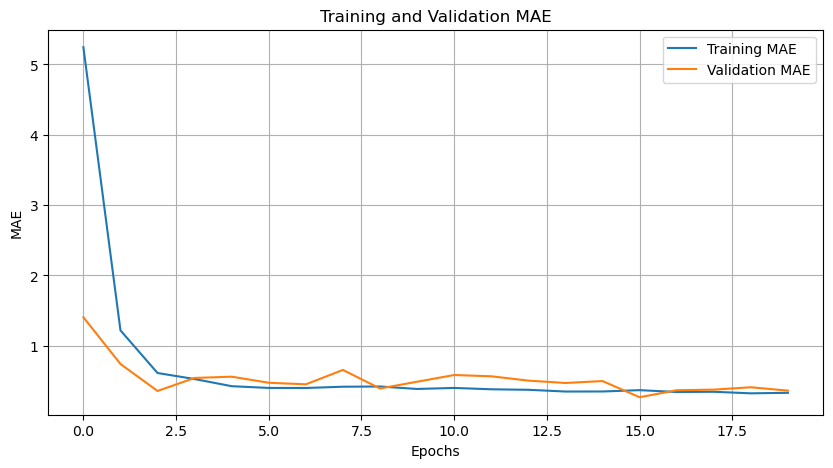

File will be saved as: Densenet_model_20_epoch_0.001_LR_adam_optimizer_32_batch_size.png


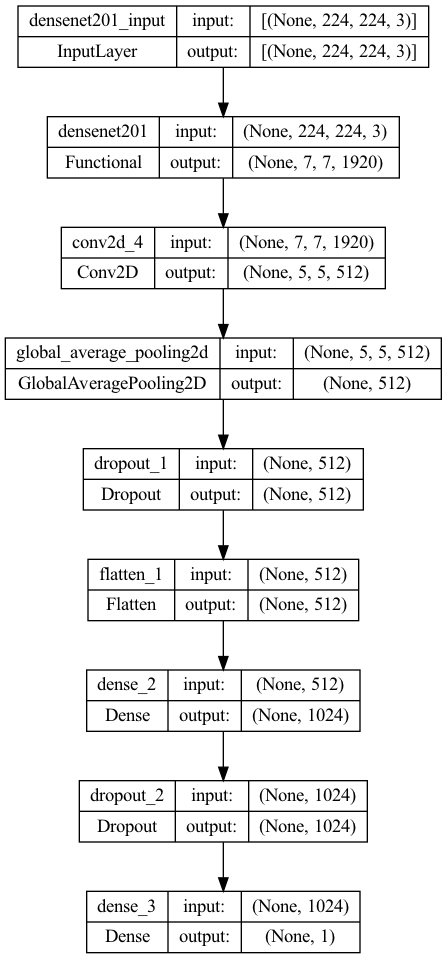

1/1 [==============================] - 3s 3s/step
19.45730948448181


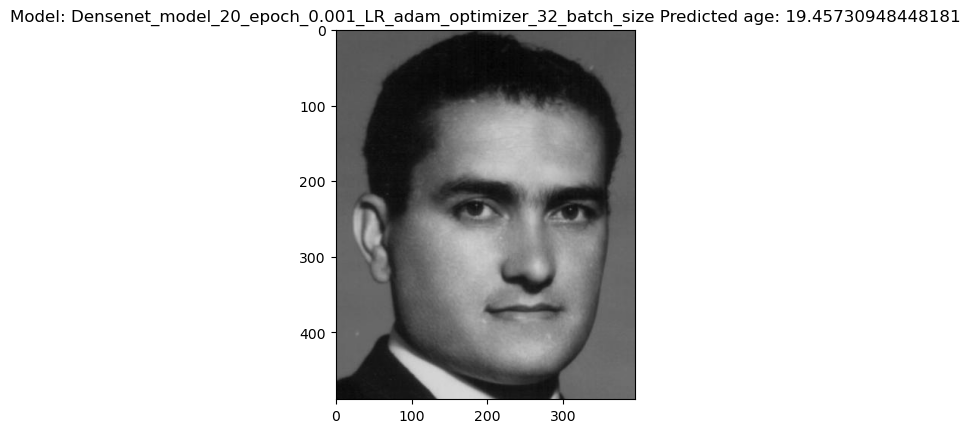

In [14]:
train_test_densenet(trainX, trainY, testX, testY, "adam", IMAGE_SIZE, BATCH_SIZE, 20, 0.001)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 512)         8847872   
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              525312    
                                                      

7/7 [==============================] - 8s 555ms/step


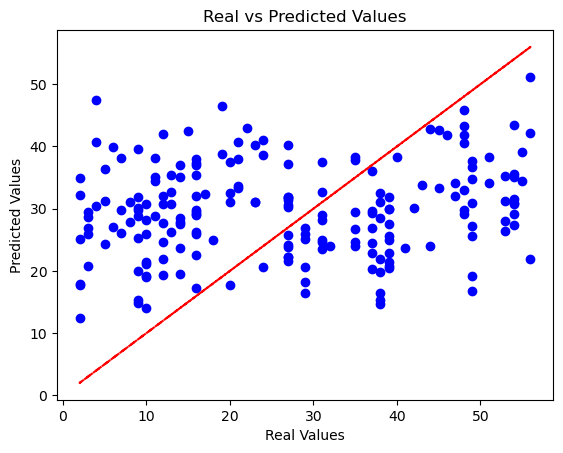

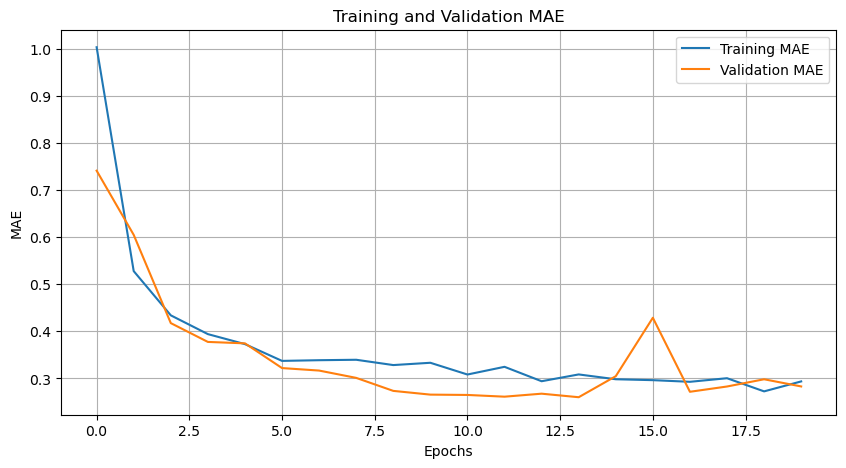

File will be saved as: Densenet_model_20_epoch_0.0001_LR_adam_optimizer_32_batch_size.png


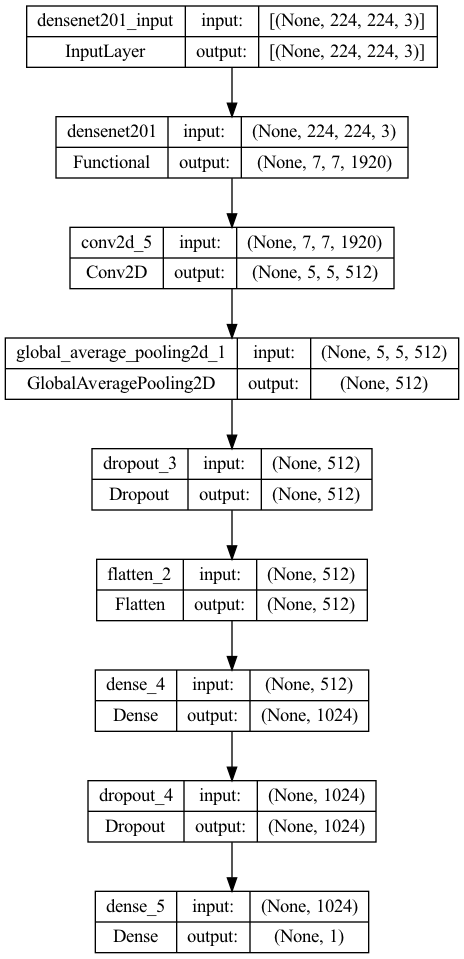

1/1 [==============================] - 3s 3s/step
35.06949758529663


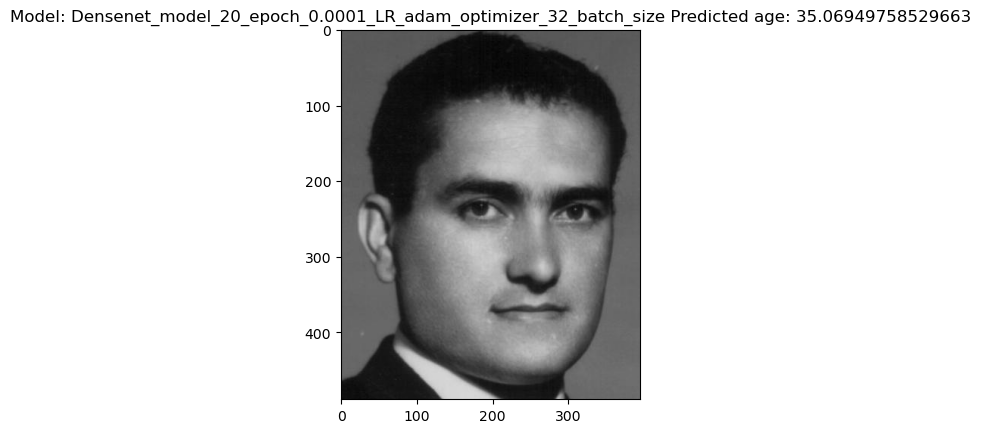

In [15]:
train_test_densenet(trainX, trainY, testX, testY, "adam", IMAGE_SIZE, BATCH_SIZE, 20, 0.0001)
#overfitting

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 5, 512)         8847872   
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                      

7/7 [==============================] - 6s 458ms/step


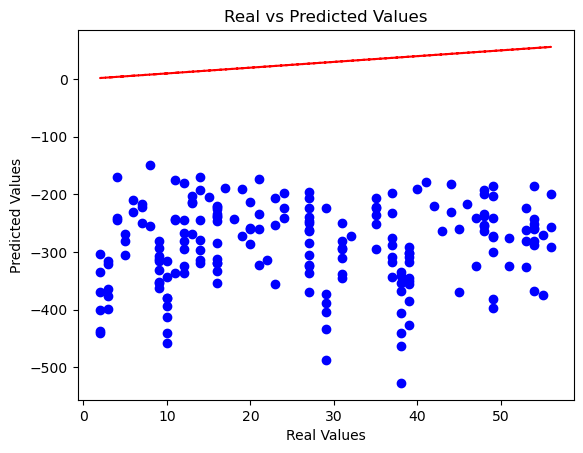

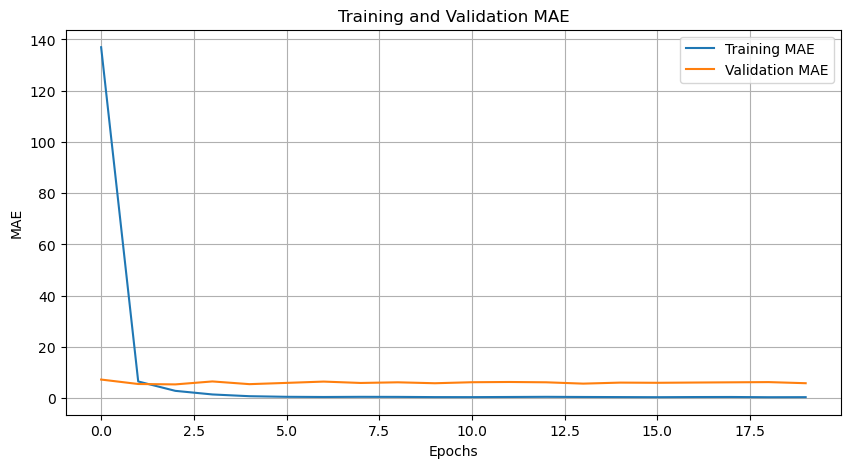

File will be saved as: Densenet_model_20_epoch_0.01_LR_adam_optimizer_32_batch_size.png


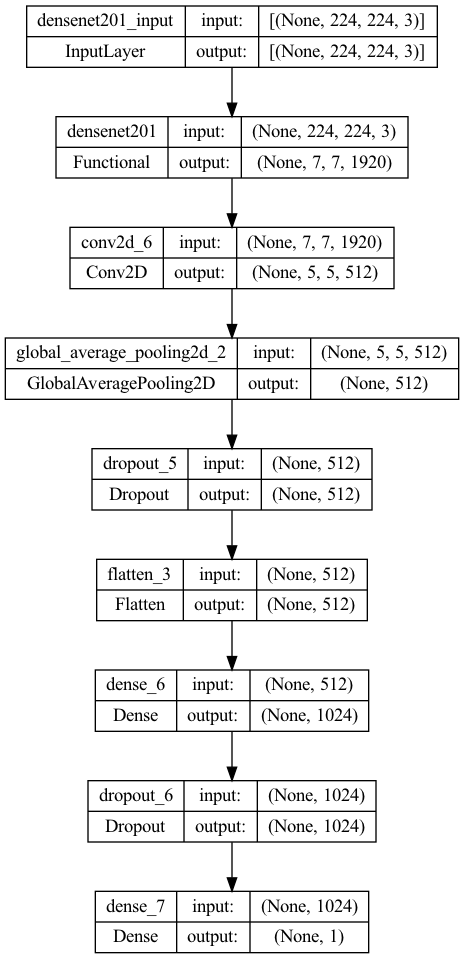

1/1 [==============================] - 4s 4s/step
-323.9531021118164


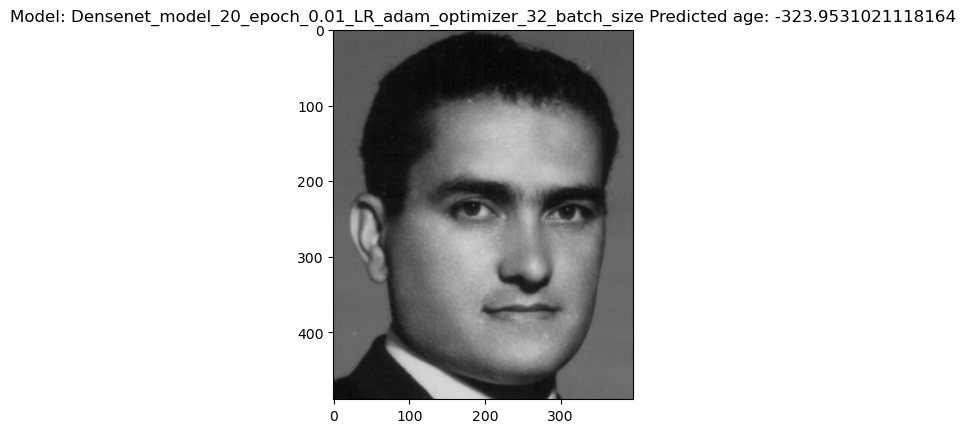

In [16]:
#train_test_densenet(trainX, trainY, testX, testY, "adam", IMAGE_SIZE, 64, 20, 0.0001)
train_test_densenet(trainX, trainY, testX, testY, "adam", IMAGE_SIZE, BATCH_SIZE, 20, 0.01)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 5, 512)         8847872   
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 1024)              525312    
                                                      

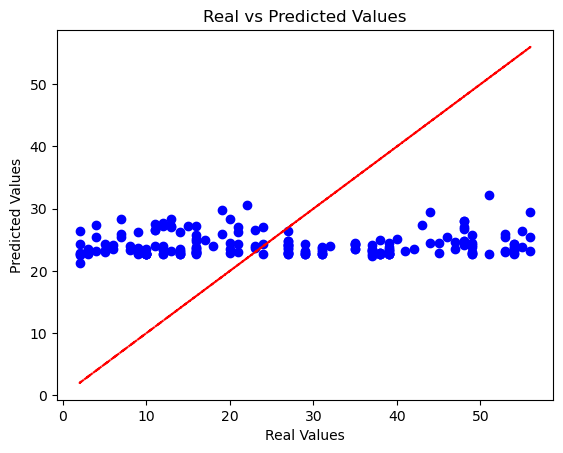

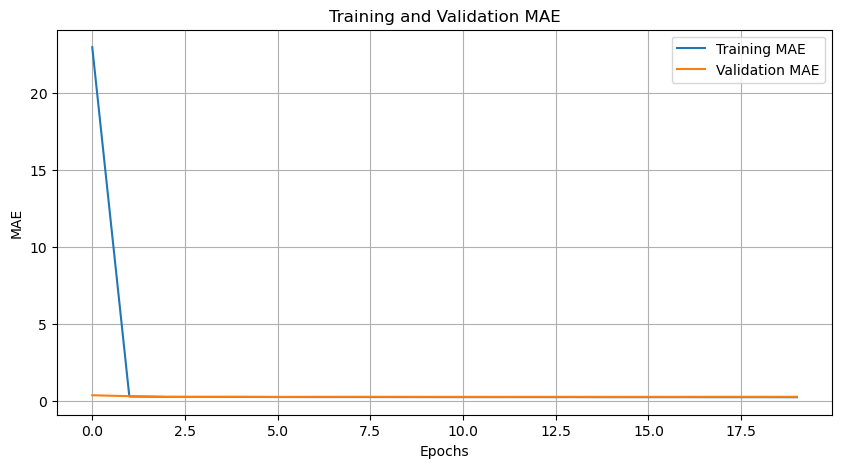

File will be saved as: Densenet_model_20_epoch_0.01_LR_sgd_optimizer_32_batch_size.png


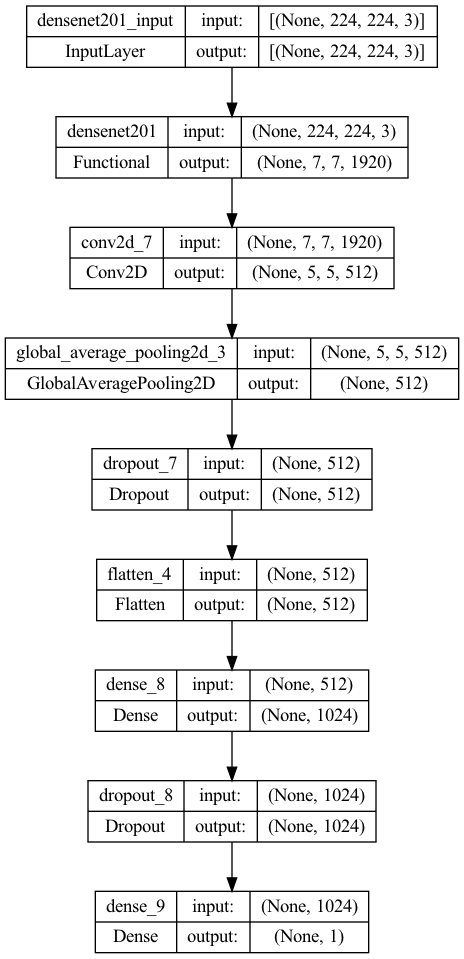

1/1 [==============================] - 4s 4s/step
23.182398080825806


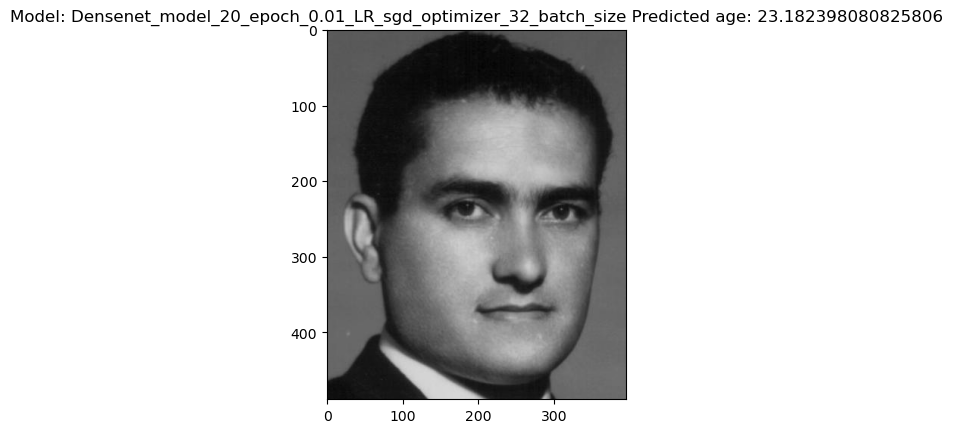

In [17]:
train_test_densenet(trainX, trainY, testX, testY, "sgd", IMAGE_SIZE, BATCH_SIZE, 20, 0.01)
#new  best model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 conv2d_8 (Conv2D)           (None, 5, 5, 512)         8847872   
                                                                 
 global_average_pooling2d_4  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 1024)              525312    
                                                      

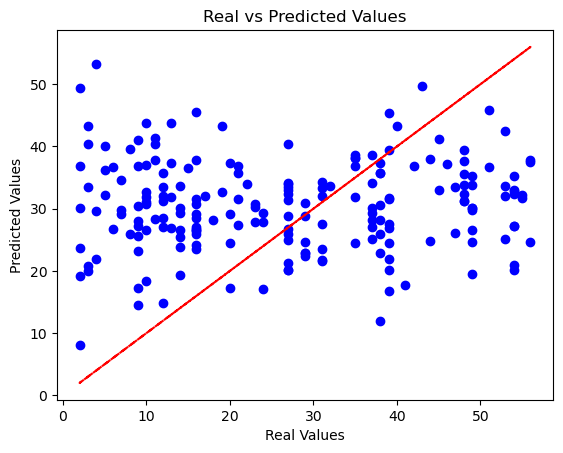

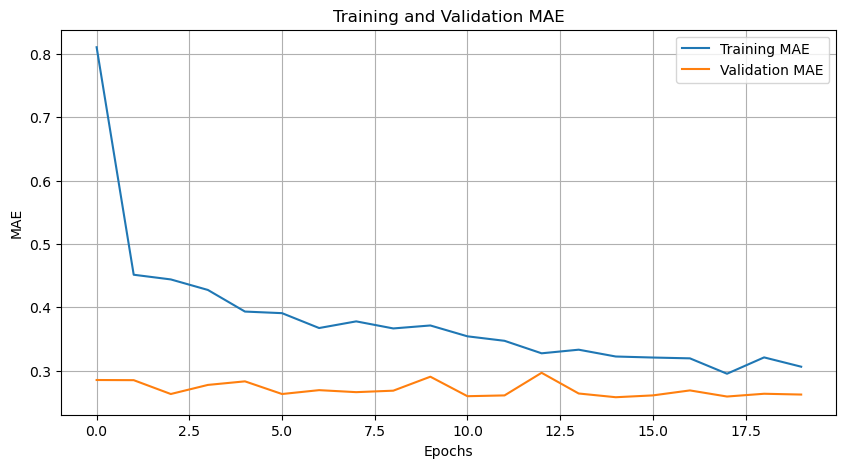

File will be saved as: Densenet_model_20_epoch_0.001_LR_sgd_optimizer_32_batch_size.png


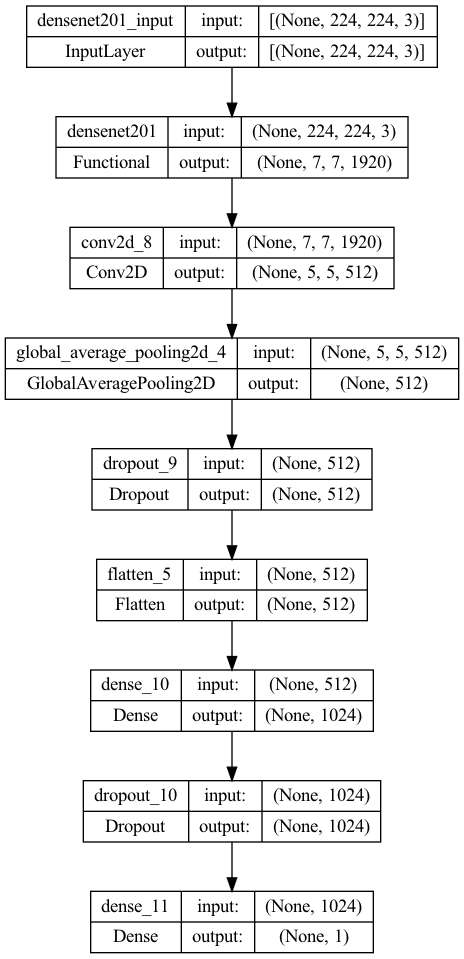

1/1 [==============================] - 5s 5s/step
20.65899920463562


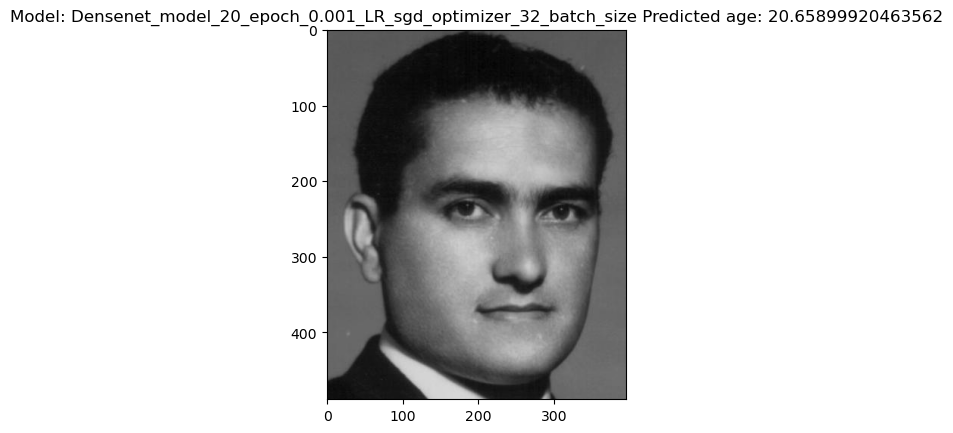

In [18]:
train_test_densenet(trainX, trainY, testX, testY, "sgd", IMAGE_SIZE, BATCH_SIZE, 20, 0.001)

# VGG Model

In [19]:
def vgg_model(trainX, trainY, testX, testY, model_name, optimizer, image_size, batch_size, epochs, lr):
    vgg_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    
    # Freeze the layers
    for layer in vgg_model.layers:
      layer.trainable = False
        
    # Create the model
    model = Sequential()
    # Add the VGG Model base model
    model.add(vgg_model)
    # Add additional convolutional layer
    model.add(Conv2D(1024, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # Add new layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    print(model.summary())
    
    # call Compile function
    compile_model(model, optimizer, lr)
    
    # Train the model
    history = model.fit(trainX, trainY, validation_split=0.2, batch_size=batch_size, epochs=epochs, verbose=2)
    y_pred = model.predict(testX)
    r2 = r2_score(testY, y_pred)
    model.save(model_name + '.h5')    

    #save the metrics in lists
    model_name_list.append(model_name.split('_')[0])
    optimizer_list.append(optimizer)
    batch_list.append(batch_size)
    learning_rate_list.append(lr)
    epoch_list.append(epochs)
    train_mae_list.append(history.history['mae'][-1])
    val_mae_list.append(history.history['val_mae'][-1])
    train_mse_list.append(history.history['mse'][-1])
    val_mse_list.append(history.history['val_mse'][-1])
    r_square_list.append(r2)

    #plotting
    plot_real_vs_predicted(testY, y_pred, MIN_AGE, MAX_AGE)
    plot_training_history(history)
    plot_model_structure(model, model_name)

In [20]:
def train_test_vgg(trainX, trainY, testX, testY, optimizer, image_size, batch_size, epochs, lr): 
    model_name = f'VGG_model_{epochs}_epoch_{lr}_LR_{optimizer}_optimizer_{batch_size}_batch_size'
    vgg_model(trainX, trainY, testX, testY, model_name, optimizer, image_size, batch_size, epochs, lr)
    # Load the trained model
    saved_model = load_model('./' + model_name + '.h5')
    # Test prediction
    testfile = IMAGEPATH + '/28/28_2.JPG'
    predict_and_plot(testfile, saved_model, model_name, MIN_AGE, MAX_AGE)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_9 (Conv2D)           (None, 5, 5, 1024)        4719616   
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 2, 2, 1024)        0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 4096)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               2097664   
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                      

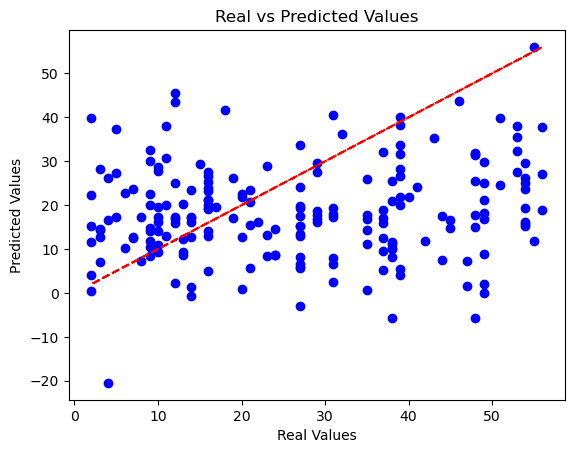

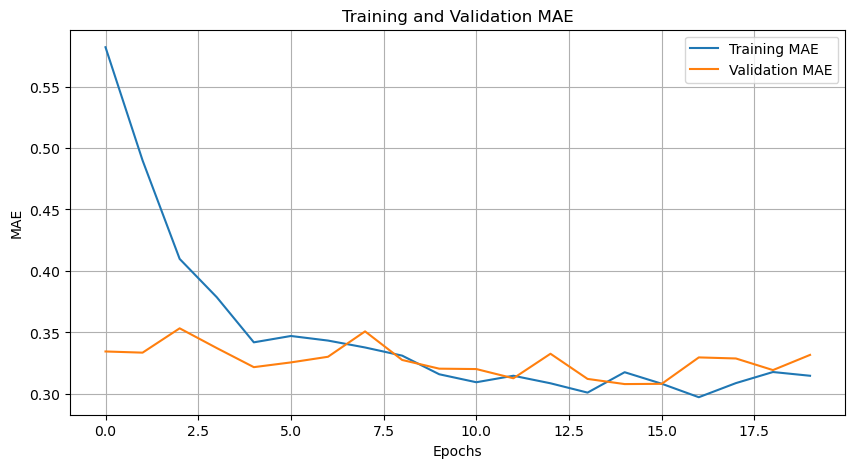

File will be saved as: VGG_model_20_epoch_0.0001_LR_sgd_optimizer_32_batch_size.png


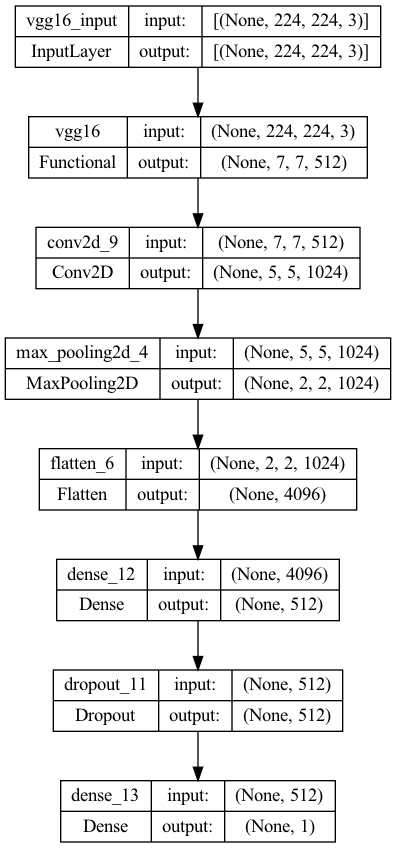

1/1 [==============================] - 0s 297ms/step
22.44033670425415


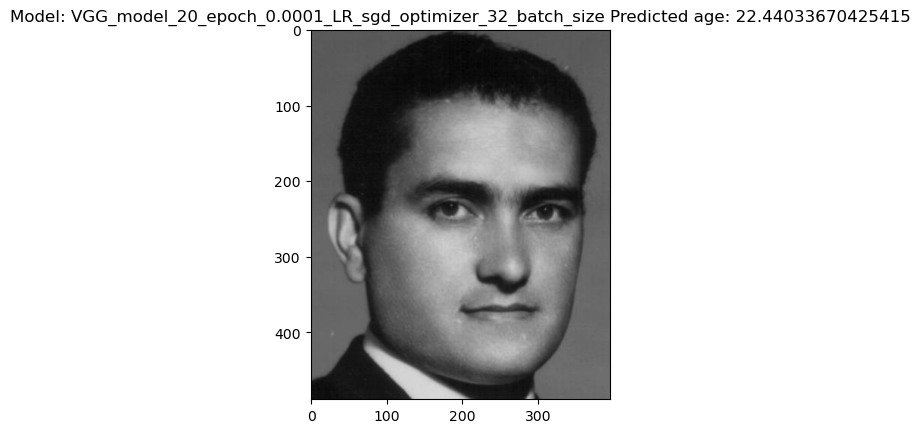

In [21]:
train_test_vgg(trainX, trainY, testX, testY, "sgd", IMAGE_SIZE, BATCH_SIZE, 20, 0.0001)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_10 (Conv2D)          (None, 5, 5, 1024)        4719616   
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 2, 2, 1024)        0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 4096)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               2097664   
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                      

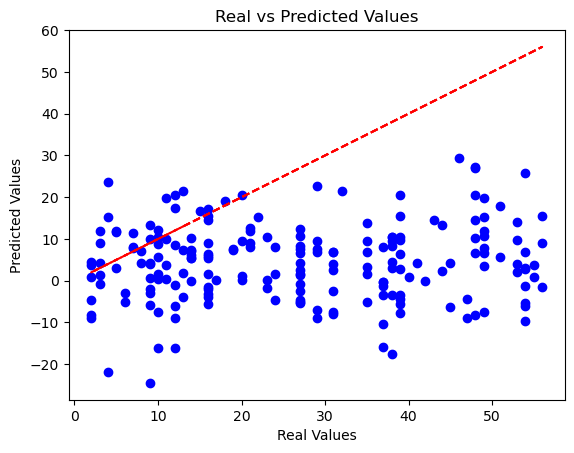

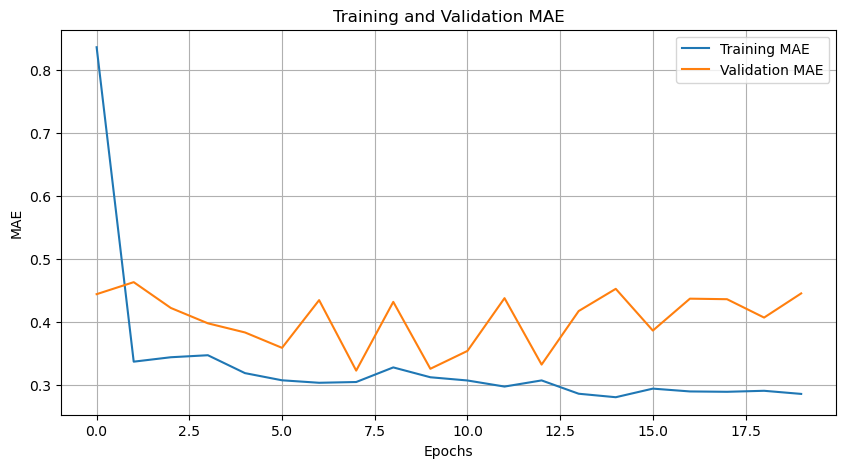

File will be saved as: VGG_model_20_epoch_0.001_LR_sgd_optimizer_32_batch_size.png


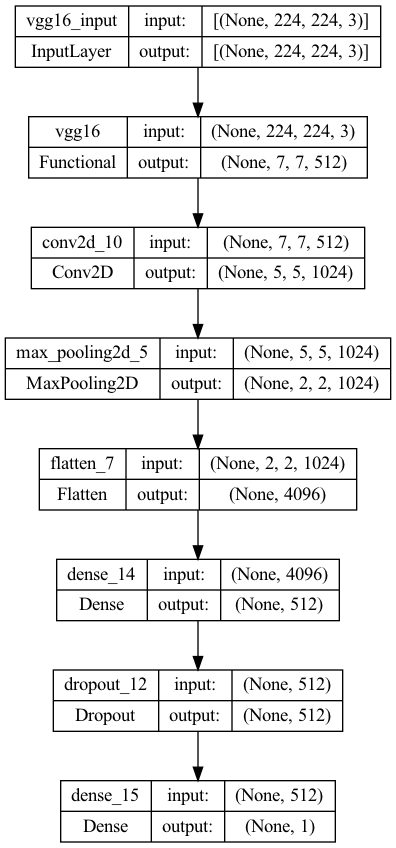

1/1 [==============================] - 0s 247ms/step
6.809343099594116


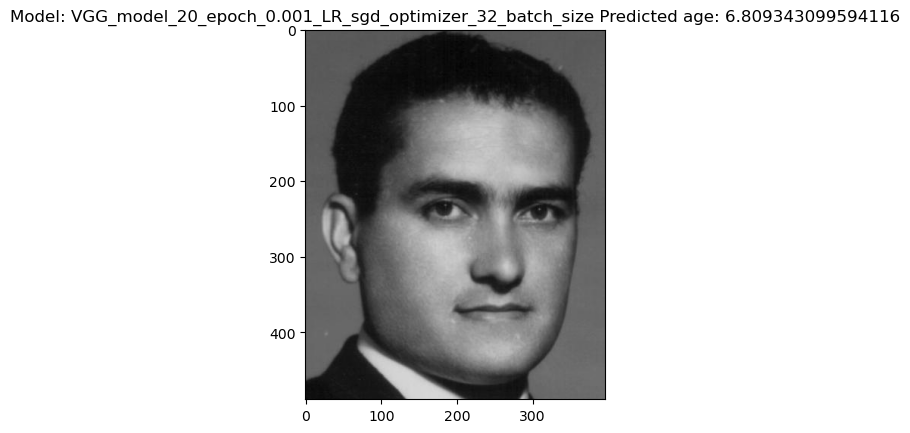

In [22]:
train_test_vgg(trainX, trainY, testX, testY, "sgd", IMAGE_SIZE, BATCH_SIZE, 20, 0.001)
#good one

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_11 (Conv2D)          (None, 5, 5, 1024)        4719616   
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 2, 2, 1024)        0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 4096)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               2097664   
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                      

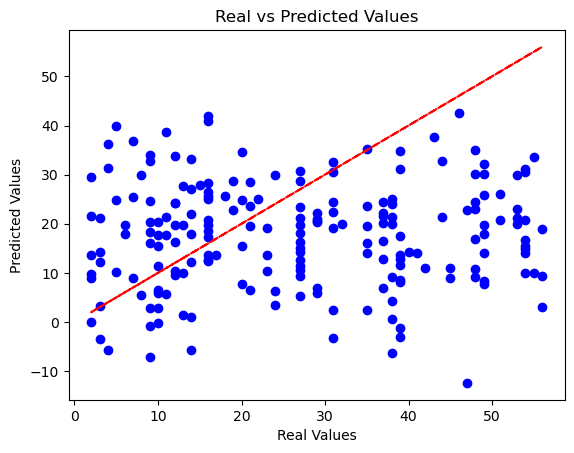

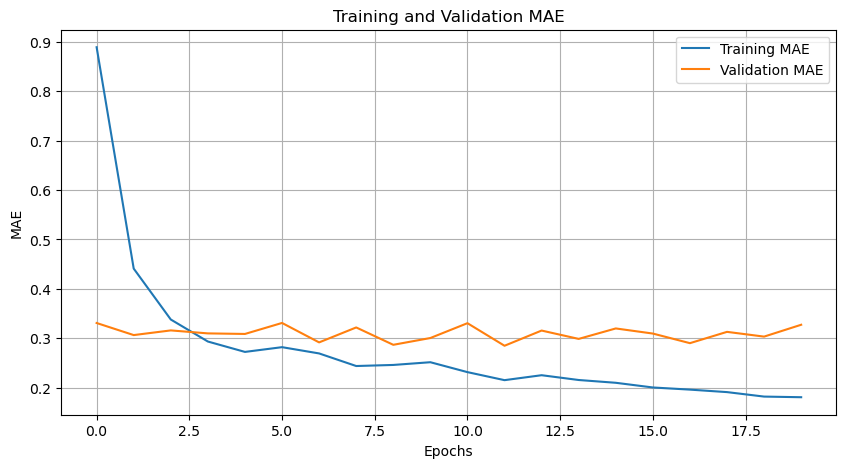

File will be saved as: VGG_model_20_epoch_0.0001_LR_adam_optimizer_32_batch_size.png


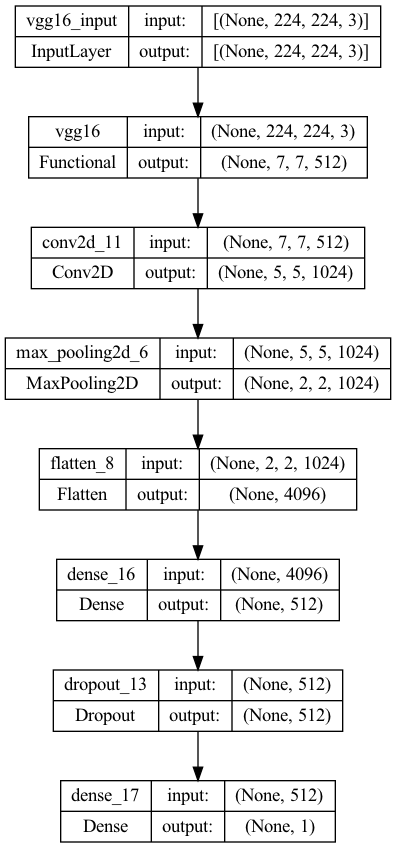

1/1 [==============================] - 0s 270ms/step
14.734087228775024


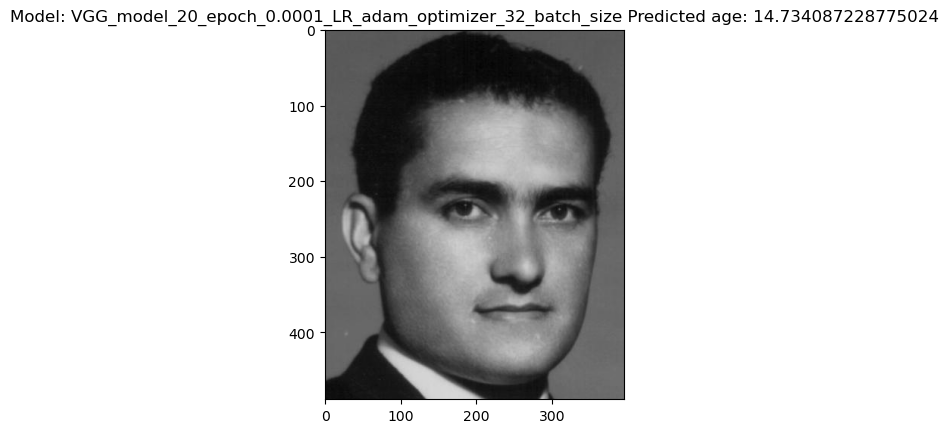

In [23]:
train_test_vgg(trainX, trainY, testX, testY, "adam", IMAGE_SIZE, BATCH_SIZE, 20, 0.0001)
#overfitting

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_12 (Conv2D)          (None, 5, 5, 1024)        4719616   
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 2, 2, 1024)        0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 4096)              0         
                                                                 
 dense_18 (Dense)            (None, 512)               2097664   
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                      

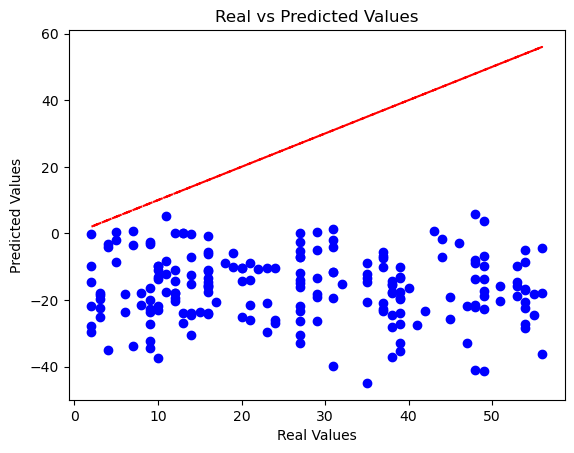

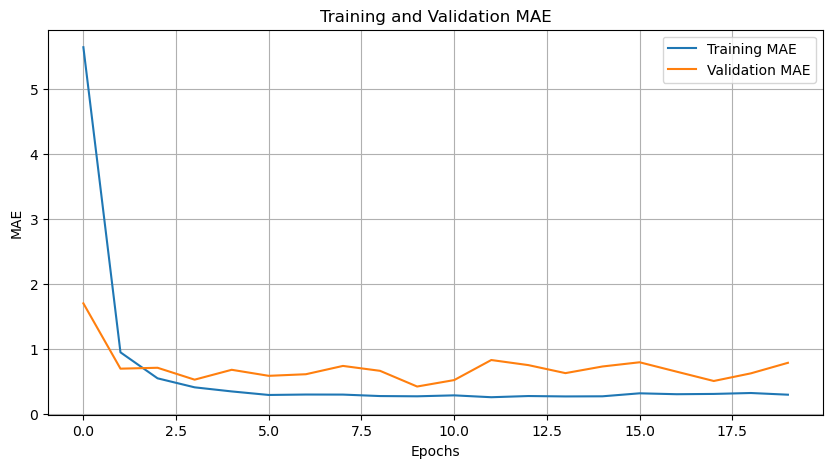

File will be saved as: VGG_model_20_epoch_0.001_LR_adam_optimizer_32_batch_size.png


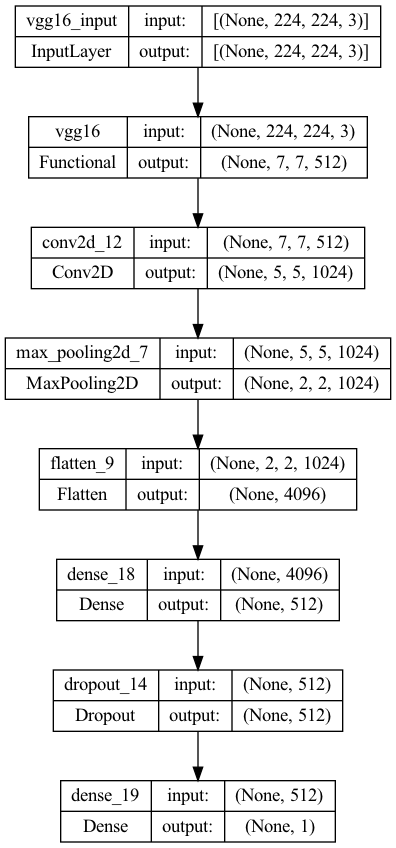

1/1 [==============================] - 0s 233ms/step
-19.685004949569702


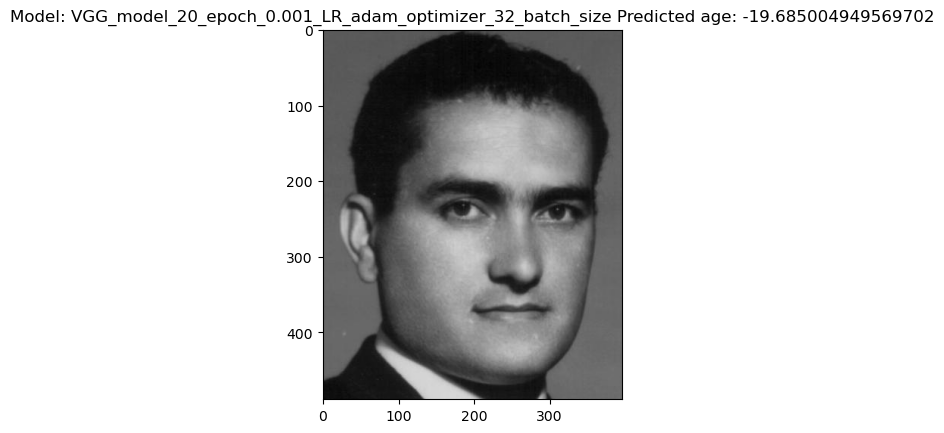

In [24]:
train_test_vgg(trainX, trainY, testX, testY, "adam", IMAGE_SIZE, BATCH_SIZE, 20, 0.001)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_13 (Conv2D)          (None, 5, 5, 1024)        4719616   
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 2, 2, 1024)        0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 4096)              0         
                                                                 
 dense_20 (Dense)            (None, 512)               2097664   
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                     

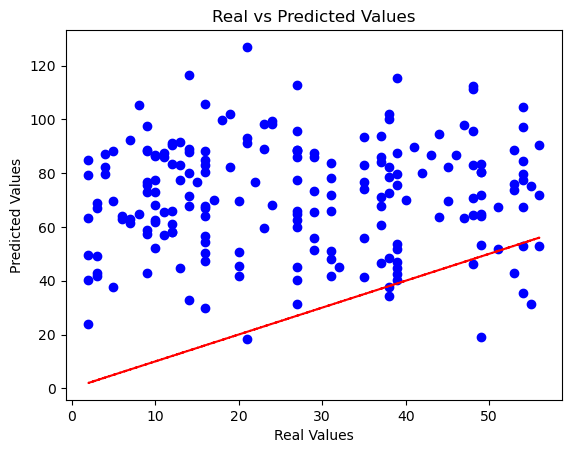

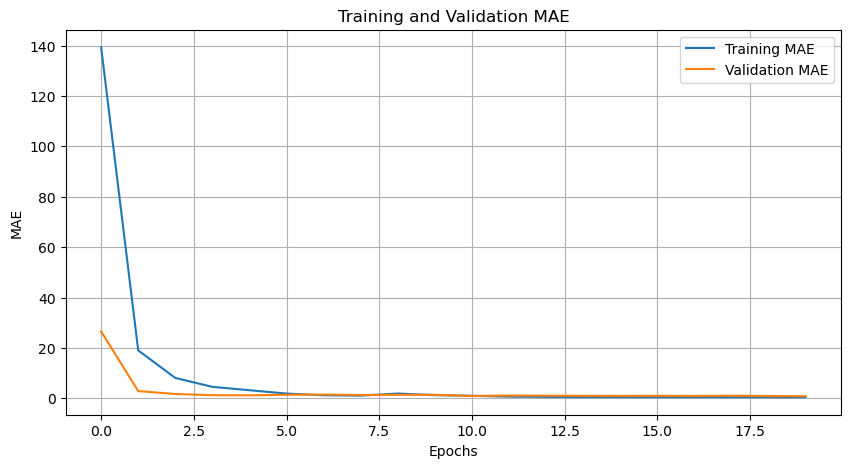

File will be saved as: VGG_model_20_epoch_0.01_LR_adam_optimizer_32_batch_size.png


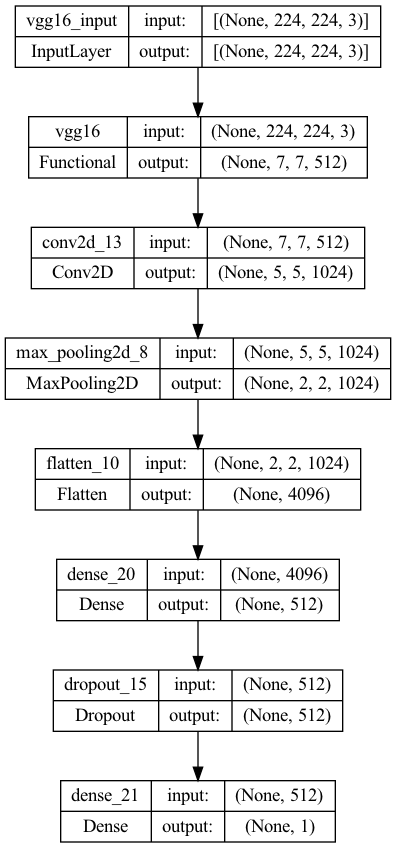

1/1 [==============================] - 0s 263ms/step
62.383530616760254


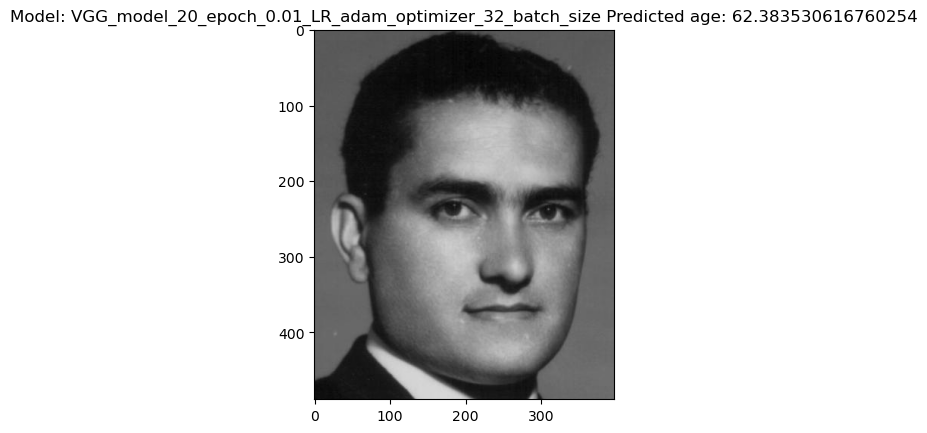

In [25]:
train_test_vgg(trainX, trainY, testX, testY, "adam", IMAGE_SIZE, BATCH_SIZE, 20, 0.01)

# Resnet Model

In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def resnet_model(trainX, trainY, testX, testY, model_name, optimizer, image_size, batch_size, epochs, lr):
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    for layer in resnet_model.layers:
      layer.trainable = False
        
    # Create the model
    model = Sequential()
    # Add the resnet Model base model
    model.add(resnet_model)
    # Add additional convolutional layer
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # Add new layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    print(model.summary())
    
    # call Compile function
    compile_model(model, optimizer, lr)
    
    # Train the model
    history = model.fit(trainX, trainY, validation_split=0.2, batch_size=batch_size, epochs=epochs, verbose=2)
   
    y_pred = model.predict(testX)
    r2 = r2_score(testY, y_pred)
    model.save(model_name + '.h5')    

    #save the metrics in lists
    model_name_list.append(model_name.split('_')[0])
    optimizer_list.append(optimizer)
    batch_list.append(batch_size)
    learning_rate_list.append(lr)
    epoch_list.append(epochs)
    train_mae_list.append(history.history['mae'][-1])
    val_mae_list.append(history.history['val_mae'][-1])
    train_mse_list.append(history.history['mse'][-1])
    val_mse_list.append(history.history['val_mse'][-1])
    r_square_list.append(r2)

    #plotting
    plot_real_vs_predicted(testY, y_pred, MIN_AGE, MAX_AGE)
    plot_training_history(history)
    plot_model_structure(model, model_name)

In [27]:
def train_test_resnet(trainX, trainY, testX, testY, optimizer, image_size, batch_size, epochs, lr): 
    model_name = f'Resnet_model_{epochs}_epoch_{lr}_LR_{optimizer}_optimizer_{batch_size}_batch_size'
    trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

    resnet_model(trainX, trainY, testX, testY, model_name, optimizer, image_size, batch_size, epochs, lr)
    # Load the trained model
    saved_model = load_model('./' + model_name + '.h5')
    # Test prediction
    testfile = IMAGEPATH + '/28/28_2.JPG'
    predict_and_plot(testfile, saved_model, model_name, MIN_AGE, MAX_AGE)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_14 (Conv2D)          (None, 5, 5, 512)         9437696   
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 2, 2, 512)         0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 2048)              0         
                                                                 
 dense_22 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                     

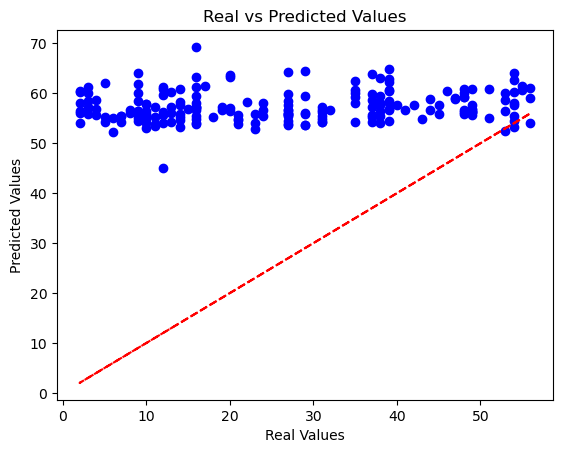

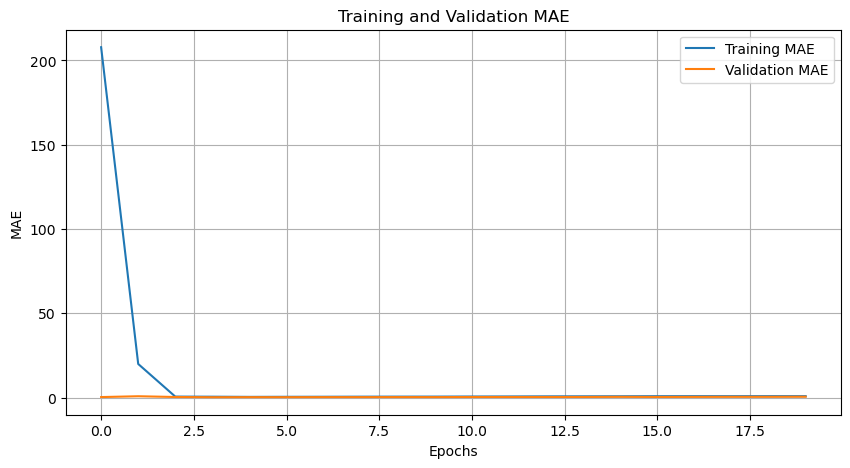

File will be saved as: Resnet_model_20_epoch_0.01_LR_adam_optimizer_32_batch_size.png


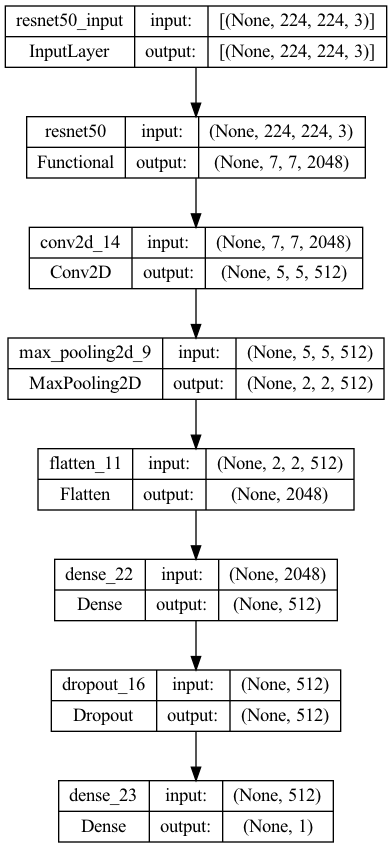

1/1 [==============================] - 1s 1s/step
60.9822301864624


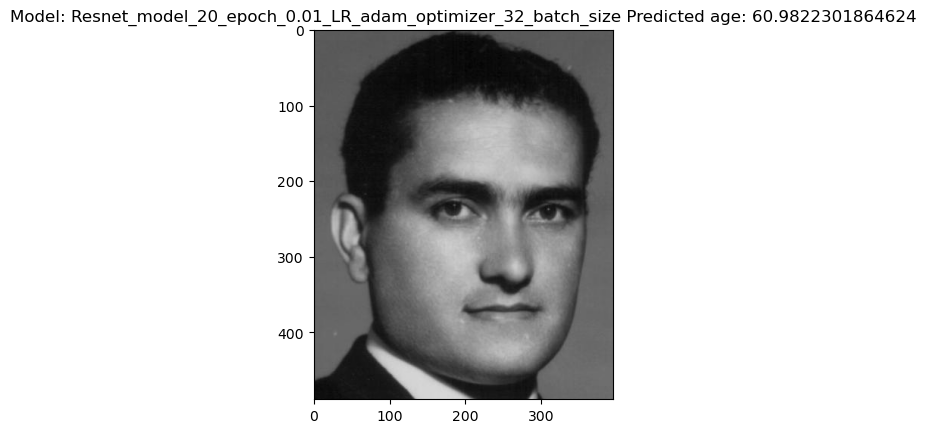

In [28]:
train_test_resnet(trainX, trainY, testX, testY, "adam", IMAGE_SIZE, BATCH_SIZE, 20, 0.01)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_15 (Conv2D)          (None, 5, 5, 512)         9437696   
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 2, 2, 512)         0         
 ng2D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 2048)              0         
                                                                 
 dense_24 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_17 (Dropout)        (None, 512)               0         
                                                     

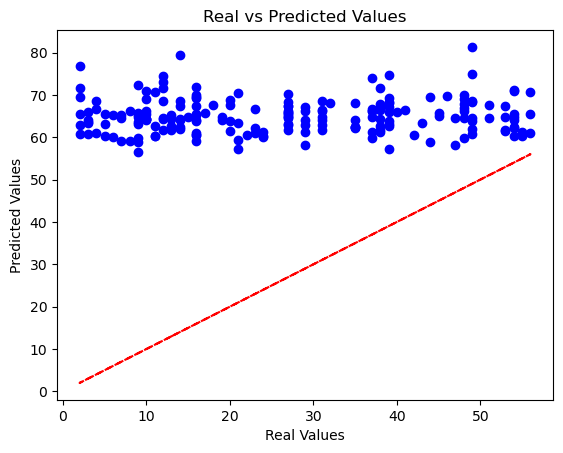

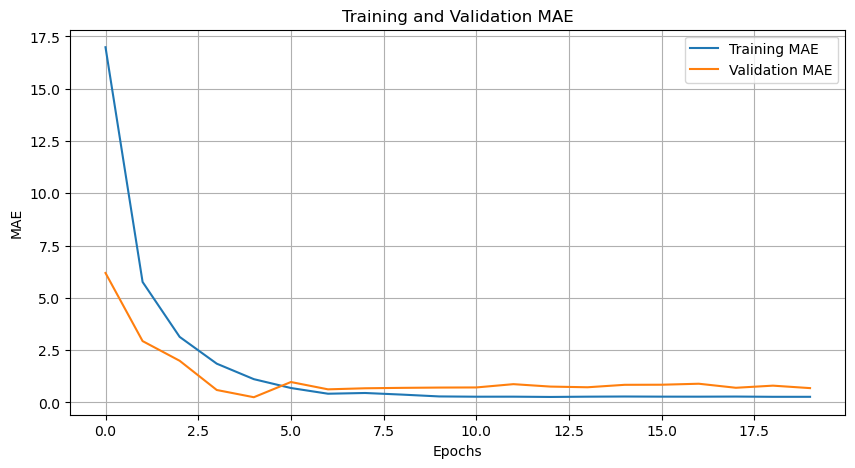

File will be saved as: Resnet_model_20_epoch_0.001_LR_adam_optimizer_32_batch_size.png


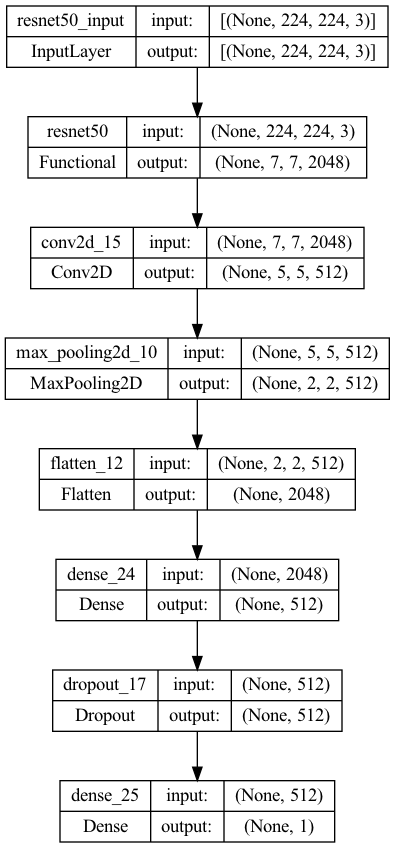

1/1 [==============================] - 1s 1s/step
67.13745784759521


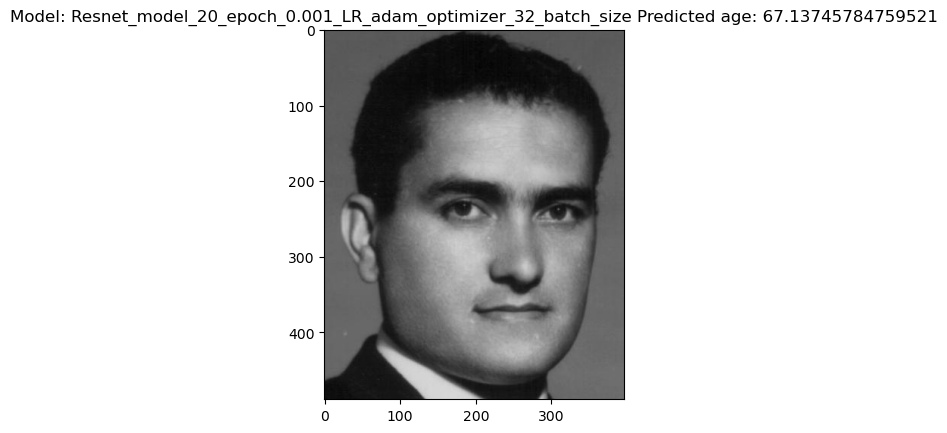

In [29]:
train_test_resnet(trainX, trainY, testX, testY, "adam", IMAGE_SIZE, BATCH_SIZE, 20, 0.001)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_17 (Conv2D)          (None, 5, 5, 512)         9437696   
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 2, 2, 512)         0         
 ng2D)                                                           
                                                                 
 flatten_14 (Flatten)        (None, 2048)              0         
                                                                 
 dense_28 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                     

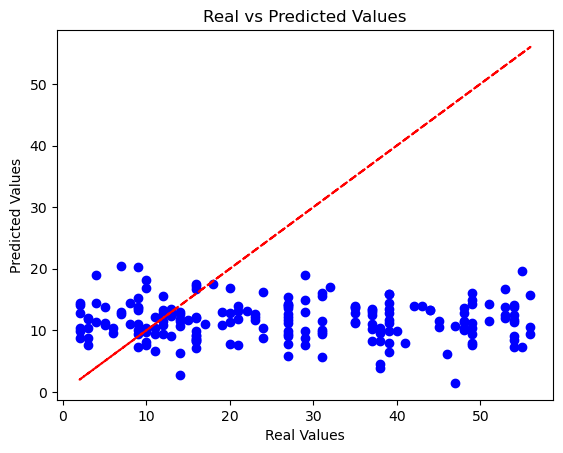

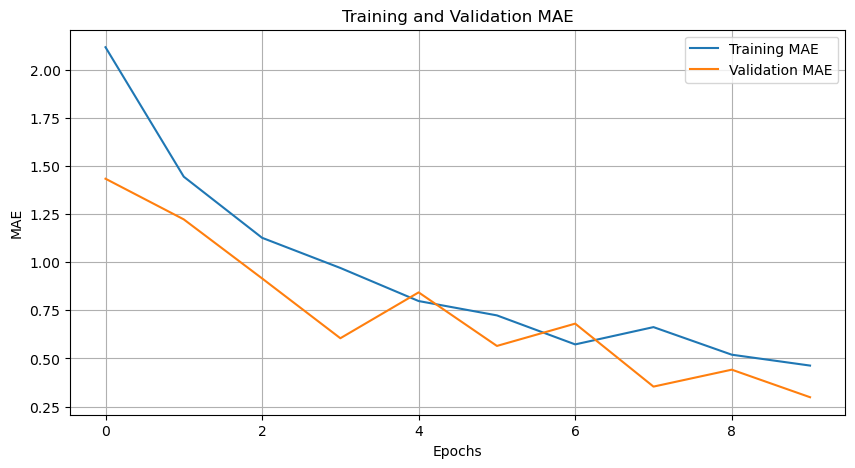

File will be saved as: Resnet_model_10_epoch_0.0001_LR_sgd_optimizer_32_batch_size.png


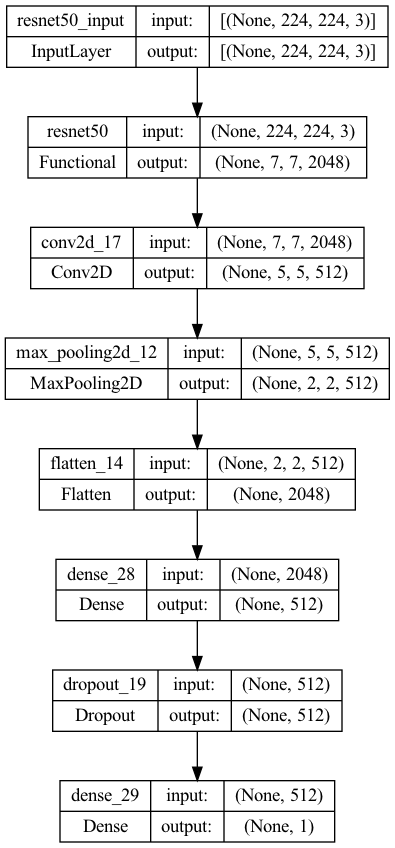

1/1 [==============================] - 1s 1s/step
11.827582120895386


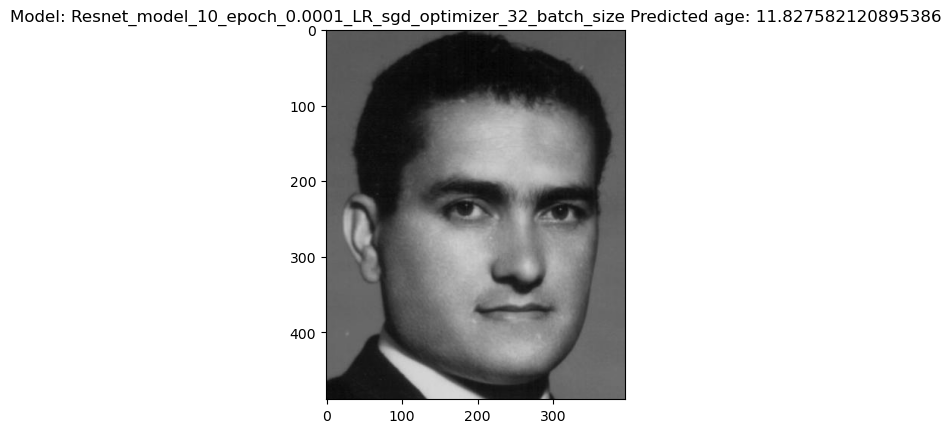

In [33]:
train_test_resnet(trainX, trainY, testX, testY, "sgd", IMAGE_SIZE, BATCH_SIZE, 10, 0.0001)

In [34]:
data = {
    'Name' : model_name_list,
    'Batch' :batch_list,
    'Optimizer' : optimizer_list,
    'Rate':learning_rate_list,
    'Epoch':epoch_list,
    'Train MAE':train_mae_list,
    'Val MAE':val_mae_list,
    'Train MSE':train_mse_list,
    'Val MSE':val_mse_list,
    'R2 Score':r_square_list
}

result_df = pd.DataFrame(data)

print(result_df)

sorted_result_df = result_df.sort_values(by='Val MSE', ascending=True)

sorted_result_df.to_csv("model_comparision_result.csv", index=False)

        Name  Batch Optimizer    Rate  Epoch  Train MAE   Val MAE  Train MSE  \
0   Densenet     32      adam  0.0010     20   0.330575  0.361435   0.175572   
1   Densenet     32      adam  0.0001     20   0.293578  0.282901   0.128680   
2   Densenet     32      adam  0.0100     20   0.414334  5.857430   0.322781   
3   Densenet     32       sgd  0.0100     20   0.241009  0.269887   0.077666   
4   Densenet     32       sgd  0.0010     20   0.306010  0.262025   0.148298   
5        VGG     32       sgd  0.0001     20   0.314757  0.331724   0.148631   
6        VGG     32       sgd  0.0010     20   0.286107  0.445334   0.121179   
7        VGG     32      adam  0.0001     20   0.180733  0.327405   0.051939   
8        VGG     32      adam  0.0010     20   0.301036  0.791421   0.136780   
9        VGG     32      adam  0.0100     20   0.420063  0.809721   0.283710   
10    Resnet     32      adam  0.0100     20   0.876632  0.555179   1.167014   
11    Resnet     32      adam  0.0010   